In [ ]:
%cd /content/

import sys
if 'google.colab' in sys.modules:
  print('Running in Colab.')
  # pytorch extensions
  !pip3 install timm==0.4.12 fairscale==0.4.4

/content
Running in Colab.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fairscale: filename=fairscale-0.4.4-py3-none-any.whl size=292832 sha256=dfe4b5b91fcb6171fa9d3eeebc6690a2611e8dbaafe07d7637ef8f612728e849
  Stored in directory: /root/.cache/pip/wheels/08/58/6f/56c57fa8315eb0bcf0287b580c850845be5f116359b809e9f1
Successfully built fairscale


In [ ]:
!pip install diffusers transformers accelerate safetensors peft bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 6.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE = "YOUR-DRIVE-FOLDER"

Mounted at /content/drive


In [ ]:
device = "cuda"

In [ ]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel, DPMSolverMultistepScheduler
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from peft import LoraConfig, get_peft_model
from peft.utils import get_peft_model_state_dict

import glob
import os
import json
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import copy
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import bitsandbytes as bnb




The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
print(torch.__version__, torch.cuda.is_available())

2.1.0+cu121 True


#ハイパラ

In [ ]:
class CFG:
  pretrained_model = "waifu-diffusion/wd-1-5-beta3"

  batch_size=12
  height=512
  width=384
  lr=8e-05
  lr_scheduler="constant"
  max_epochs=85
  num_warmup_steps=100
  gradient_accumulation_steps = 2

#教師データを用意する
BLIPによる自動キャプションを利用する

In [ ]:
import zipfile
# フォルダ「images_resized」を解凍する
folder_name = "YOUR-ZIP-FOLDER-NAME"

zip = zipfile.ZipFile(f"YOUR-DRIVE-PATH/{folder_name}.zip")


zip.extractall()  # ZIPを解凍
zip.close()  # ZIPファイルをクローズ

In [ ]:
def load_images(image_paths):
  images = []
  for im in image_paths:
    try:
      images.append(
          Image.open(im).convert("RGB")
      )
    except:
      continue
  return images

def create_path(img_dir: str, image_filenames: list):
  imgs_path = []
  for i in range(len(image_filenames)):
    if image_filenames[i].endswith(".jpg"):
      imgs_path.append(os.path.join(img_dir, image_filenames[i]))

  return imgs_path

In [ ]:
img_dir = "YOUR-FOLDER-NAME"

image_filenames = os.listdir(img_dir)

In [ ]:
imgs_path = create_path(img_dir=img_dir, image_filenames=image_filenames)
len(imgs_path), imgs_path[1]

(55, 'clair_sama/frame_531.jpg')

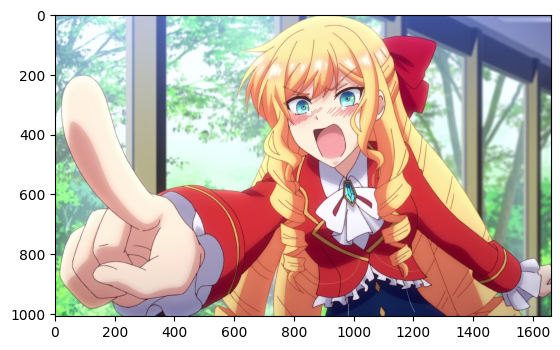

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

imgs = Image.open(str(imgs_path[1])).convert('RGB')
plt.imshow(np.array(imgs))

#データセットクラスを定義する

In [ ]:
def tokenize_captions(captions, tokenizer):
  inputs = tokenizer(
      captions, max_length=tokenizer.model_max_length, padding="max_length",
      truncation=True,
  )
  for k, v in inputs.items():
    inputs[k] = torch.tensor(v, dtype=torch.long)
  return inputs.input_ids

In [ ]:
from torch.utils.data import Dataset, DataLoader

class DiffusionDataset(Dataset):
  def __init__(self, df, tokenizer, transforms):
    self.df = df
    self.image_filenames = df.image_filenames.values
    self.captions = df.captions.values
    self.transforms = transforms

    self.input_ids = tokenize_captions(self.df.captions.to_list(), tokenizer)

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self, index):
    # print(index)
    # print(self.image_filenames[index])
    pixel_values = load_images([self.image_filenames[index]])[0]
    pixel_values = self.transforms(pixel_values)

    return pixel_values, self.input_ids[index]

In [ ]:
df = pd.read_csv(os.path.join(DRIVE, "tags_clair_sama.csv"), header=0)
# 行の名前を変えて
df = df.rename(columns={'tags': 'captions'})

df.head()

,image_filenames,captions
0,frame_1032.jpg,"clairsama, 1girl, blonde hair, closed eyes, dr..."
1,frame_1033.jpg,"clairsama, 1girl, blonde hair, closed eyes, dr..."
2,frame_1085.jpg,"clairsama, 1girl, :d, blonde hair, blurry, blu..."
3,frame_1157.jpg,"clairsama, 1girl, blonde hair, blue eyes, blur..."
4,frame_119.jpg,"clairsama, 1girl, blonde hair, book, bow, dres..."


In [ ]:
print(df.captions[0])
print(df.captions.values[0])
print(df.image_filenames[0])
print(df.image_filenames.values[0])


clairsama, 1girl, blonde hair, closed eyes, dress, flower, gradient background, jewelry, solo, sparkle, upper body, 
clairsama, 1girl, blonde hair, closed eyes, dress, flower, gradient background, jewelry, solo, sparkle, upper body, 
frame_1032.jpg
frame_1032.jpg


In [ ]:
def create_path_df(base_dir: str, df):

  for row in range(len(df)):
        name = df.iloc[row, 0]
        path = os.path.join(base_dir, name)
        # print(name)
        # print(path)
        df.iloc[row, 0] = path

  return df


df = create_path_df(img_dir, df)
df.head()

,image_filenames,captions
0,clair_sama/frame_1032.jpg,"clairsama, 1girl, blonde hair, closed eyes, dr..."
1,clair_sama/frame_1033.jpg,"clairsama, 1girl, blonde hair, closed eyes, dr..."
2,clair_sama/frame_1085.jpg,"clairsama, 1girl, :d, blonde hair, blurry, blu..."
3,clair_sama/frame_1157.jpg,"clairsama, 1girl, blonde hair, blue eyes, blur..."
4,clair_sama/frame_119.jpg,"clairsama, 1girl, blonde hair, book, bow, dres..."


In [ ]:
df.iloc[0, :]

image_filenames                            clair_sama/frame_1032.jpg
captions           clairsama, 1girl, blonde hair, closed eyes, dr...
Name: 0, dtype: object

In [ ]:
len(df["image_filenames"]), len(imgs_path)

(55, 55)

In [ ]:
print(df.captions[0])
print(df.image_filenames[0])


clairsama, 1girl, blonde hair, closed eyes, dress, flower, gradient background, jewelry, solo, sparkle, upper body, 
clair_sama/frame_1032.jpg


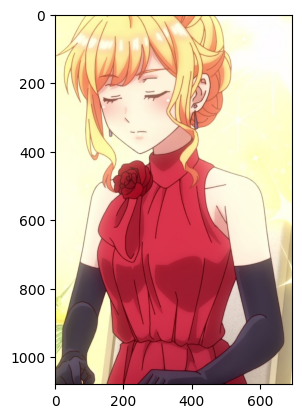

In [ ]:
imgs = Image.open(str(df["image_filenames"][0])).convert('RGB')
plt.imshow(np.array(imgs))

#諸々のモデルを用意する

In [ ]:
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers.utils import convert_state_dict_to_diffusers


In [ ]:
from accelerate import Accelerator


accelerator = Accelerator(
        gradient_accumulation_steps=CFG.gradient_accumulation_steps,
        mixed_precision="fp16",
        )
device = accelerator.device
device

device(type='cuda')

In [ ]:


noise_scheduler = DDPMScheduler.from_pretrained(CFG.pretrained_model, subfolder="scheduler")

tokenizer = CLIPTokenizer.from_pretrained(
    CFG.pretrained_model, subfolder="tokenizer", revision=None)

text_encoder = CLIPTextModel.from_pretrained(
    CFG.pretrained_model, subfolder="text_encoder", revision=None)

vae = AutoencoderKL.from_pretrained(CFG.pretrained_model, subfolder="vae", revision=None)

unet = UNet2DConditionModel.from_pretrained(
    CFG.pretrained_model, subfolder="unet", revision=None)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

In [ ]:
#学習するのはUNETのみなので他のモデルの勾配を計算しないように設定する

vae.requires_grad_(False)
text_encoder.requires_grad_(False)

unet.requires_grad_(False)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Linear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_f

In [ ]:
weight_dtype = torch.float16
for param in unet.parameters():
    param.requires_grad_(False)
for param in text_encoder.parameters():
    param.requires_grad_(False)

In [ ]:
for name, param in unet.named_parameters():
  print(name)

conv_in.weight
conv_in.bias
time_embedding.linear_1.weight
time_embedding.linear_1.bias
time_embedding.linear_2.weight
time_embedding.linear_2.bias
down_blocks.0.attentions.0.norm.weight
down_blocks.0.attentions.0.norm.bias
down_blocks.0.attentions.0.proj_in.weight
down_blocks.0.attentions.0.proj_in.bias
down_blocks.0.attentions.0.transformer_blocks.0.norm1.weight
down_blocks.0.attentions.0.transformer_blocks.0.norm1.bias
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.weight
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.weight
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.weight
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.weight
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.bias
down_blocks.0.attentions.0.transformer_blocks.0.norm2.weight
down_blocks.0.attentions.0.transformer_blocks.0.norm2.bias
down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q.weight
down_blocks.0.attentions.0.transformer_blocks.0.attn

In [ ]:
for name, param in text_encoder.named_parameters():
  print(name)

text_model.embeddings.token_embedding.weight
text_model.embeddings.position_embedding.weight
text_model.encoder.layers.0.self_attn.k_proj.weight
text_model.encoder.layers.0.self_attn.k_proj.bias
text_model.encoder.layers.0.self_attn.v_proj.weight
text_model.encoder.layers.0.self_attn.v_proj.bias
text_model.encoder.layers.0.self_attn.q_proj.weight
text_model.encoder.layers.0.self_attn.q_proj.bias
text_model.encoder.layers.0.self_attn.out_proj.weight
text_model.encoder.layers.0.self_attn.out_proj.bias
text_model.encoder.layers.0.layer_norm1.weight
text_model.encoder.layers.0.layer_norm1.bias
text_model.encoder.layers.0.mlp.fc1.weight
text_model.encoder.layers.0.mlp.fc1.bias
text_model.encoder.layers.0.mlp.fc2.weight
text_model.encoder.layers.0.mlp.fc2.bias
text_model.encoder.layers.0.layer_norm2.weight
text_model.encoder.layers.0.layer_norm2.bias
text_model.encoder.layers.1.self_attn.k_proj.weight
text_model.encoder.layers.1.self_attn.k_proj.bias
text_model.encoder.layers.1.self_attn.v_p

In [ ]:
unet_lora_config = LoraConfig(
        r=16, lora_alpha=12, init_lora_weights="gaussian",
        # target_modules=["to_k", "to_q", "to_v", "to_out.0"],
        target_modules=["to_k", "to_q", "to_v", "to_out.0", "conv1", "conv2"]
        # target_modules=["to_k", "to_q", "to_v", "to_out.0", "add_k_proj", "add_v_proj"]
    )

text_encoder_lora_config = LoraConfig(
        r=16, lora_alpha=12, init_lora_weights="gaussian",
        # target_modules=["to_k", "to_q", "to_v", "to_out.0"],
        # target_modules=["k_proj", "v_proj", "q_proj", "fc1", "fc2"]
        target_modules=["q_proj", "k_proj", "v_proj", "out_proj"]
    )

In [ ]:
# Move unet, vae and text_encoder to device and cast to weight_dtype

# keep the unet in float 32
unet.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)
text_encoder.to(accelerator.device, dtype=weight_dtype)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1024)
      (position_embedding): Embedding(77, 1024)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-22): 23 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Add adapter and make sure the trainable params are in float32.

unet.add_adapter(unet_lora_config)
for param in unet.parameters():
  # only upcast trainable parameters (LoRA) into fp32
  if param.requires_grad:
    param.data = param.to(torch.float32)

count_parameters(unet)

11153408

In [ ]:
# Add adapter and make sure the trainable params are in float32.
text_encoder.add_adapter(text_encoder_lora_config)
for param in text_encoder.parameters():
  # only upcast trainable parameters (LoRA) into fp32
  if param.requires_grad:
    param.data = param.to(torch.float32)

count_parameters(text_encoder)

3014656

In [ ]:
unet_lora_layers = filter(lambda p: p.requires_grad, unet.parameters())
text_encoder_lora_layers = filter(lambda p: p.requires_grad, text_encoder.parameters())

In [ ]:
params_to_optimize = list(unet_lora_layers) + list(text_encoder_lora_layers)


In [ ]:
print("Memory if using AdamW(8 bytes per parameters): ")
print(((count_parameters(unet) + count_parameters(text_encoder)) * 8) / 1000000, "MBytes")

Memory if using AdamW(8 bytes per parameters): 
113.344512 MBytes


#学習処理実装

##生のピクセル値にノイズを付与する処理

In [ ]:
def make_some_noise(pixel_values, vae, noise_scheduler):
  latents = vae.encode(pixel_values.to(dtype=weight_dtype)).latent_dist.sample()
  latents = latents * vae.config.scaling_factor

  # Create noise
  noise = torch.randn_like(latents)
  bsz = latents.shape[0]

  # Sample a random timestep for each image
  timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,),
                            device=latents.device)
  timesteps = timesteps.long()

  noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

  return (noisy_latents, noise, latents, timesteps)

# エポックごとに行う処理

In [ ]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [ ]:
from diffusers.optimization import get_scheduler
shape = (CFG.height, CFG.width)

train_transforms = transforms.Compose([
    transforms.Resize(
        shape,
        interpolation=2,
    ),
    transforms.RandomCrop(shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

train_dataset = DiffusionDataset(
    df, tokenizer, train_transforms
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=2,
)

lr = CFG.lr * CFG.gradient_accumulation_steps * CFG.batch_size


optimizer_cls = bnb.optim.AdamW8bit

# Optimizer creation


optimizer = optimizer_cls(
        params_to_optimize,
        lr=lr,
        betas=(0.9, 0.999),
        weight_decay=1e-2,
        eps=1e-08,
    )

lr_scheduler = get_scheduler(
    CFG.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=CFG.num_warmup_steps,
    num_training_steps=int(CFG.max_epochs*len(train_dataloader))
)


In [ ]:
train_dataset[-2]

(tensor([[[ 0.0667,  0.0667,  0.0588,  ...,  0.0980,  0.0980,  0.0980],
          [ 0.0667,  0.0667,  0.0588,  ...,  0.0980,  0.0980,  0.0980],
          [ 0.0588,  0.0588,  0.0588,  ...,  0.0824,  0.0824,  0.0824],
          ...,
          [-0.8745, -0.8745, -0.8745,  ..., -0.8510, -0.8510, -0.8510],
          [-0.8745, -0.8745, -0.8745,  ..., -0.8588, -0.8588, -0.8588],
          [-0.8824, -0.8824, -0.8745,  ..., -0.8588, -0.8588, -0.8588]],
 
         [[-0.2235, -0.2235, -0.2314,  ..., -0.1922, -0.1922, -0.1922],
          [-0.2235, -0.2235, -0.2314,  ..., -0.1922, -0.1922, -0.1922],
          [-0.2314, -0.2314, -0.2314,  ..., -0.2078, -0.2078, -0.2078],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.2706, -0.2706, -0.2784,  ..., -0.2392, -0.2392, -0.2392],
          [-0.2706, -0.2706,

In [ ]:
len(train_dataloader.dataset), len(train_dataset), len(df), len(imgs_path)

(55, 55, 55, 55)

In [ ]:
# Prepare everything with our `accelerator`.
unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, text_encoder, optimizer, train_dataloader, lr_scheduler
)

In [ ]:
unet.device

device(type='cuda', index=0)

In [ ]:
for param in unet.parameters():
  # only upcast trainable parameters (LoRA) into fp32
  if param.requires_grad:
    print(param.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.

In [ ]:
for param in text_encoder.parameters():
  # only upcast trainable parameters (LoRA) into fp32
  if param.requires_grad:
    print(param.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.

In [ ]:
import torch.nn.functional as F

def train_one_epoch(
    unet,
    vae,
    noise_scheduler,
    text_encoder,
    train_dataloader,
    optimizer,
    lr_scheduler,
    losses,
  ):
  pbar = tqdm(train_dataloader)
  for (pixel_values, input_ids) in pbar:
    with accelerator.accumulate(unet):

      # ピクセル値をlatentに交換した上でノイズを付与
      (noisy_latents, noise, latents, timesteps) = make_some_noise(pixel_values,
                                                                  vae,
                                                                  noise_scheduler)
      # put embeddings to the text, encodes it
      encoder_hidden_states = text_encoder(input_ids)[0]

      # Get the target loss depending on the prediction type
      if noise_scheduler.config.prediction_type == "epsilon":
        target = noise
      elif noise_scheduler.config.prediction_type == "v_prediction":
        target = noise_scheduler.get_velocity(latents, noise, timesteps)
      else:
        raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

      model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
      loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

      # Backpropagate
      accelerator.backward(loss)
      if accelerator.sync_gradients:
          params_to_clip = params_to_optimize

          accelerator.clip_grad_norm_(params_to_clip, 1.0)
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()


      losses.update(loss.item(), len(target))
      pbar.set_description(f"average loss: {losses.avg}")

  return losses

#学習開始

In [ ]:
print(CFG.batch_size)
for batch_tupel in train_dataloader:
  print(batch_tupel[0].shape)
  print(batch_tupel[1])
  break

12
torch.Size([12, 3, 512, 384])
tensor([[49406, 31441, 19272,   267, 10711,  2225,   267,  1746,  3095,   267,
          4040,   267,  2866,  2225,   267, 11731,  5706,   267, 20795,  2225,
           267, 11626,  2225,   267,  1538,  2225,   267,  1488,  4932,   267,
           736,  3095,   267,  8318,  3243,   267,  1145, 11626,   267,  3490,
           267,  6769, 24378,   267, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406, 31441, 19272,   267,   272,  1611,   267, 10711,  2225,   267,
         21977,   267, 21977,  5994,   267, 21977, 35186,   267,  4040,   267,
         21207,   267, 10350,   539,  1570,   267, 11626,  2225,   267, 22973,
           267,  1538,  2225,   267,  1312,   536, 15061,   267,  8318,  3243,
           267,  1145, 11626,   267,  5

In [ ]:
optimizer

AcceleratedOptimizer (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0019200000000000003
    lr: 0.0019200000000000003
    weight_decay: 0.01
)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
losses = AverageMeter()

for epoch in range(CFG.max_epochs):
  unet.train()
  print("="*10)
  print(f"start {epoch+1} epochs training")

  losses = train_one_epoch(
        unet,
        vae,
        noise_scheduler,
        text_encoder,
        train_dataloader,
        optimizer,
        lr_scheduler,
        losses,
    )

  if epoch % 15 == 0 or epoch == CFG.max_epochs - 1:
    unet.eval()

    # create pipeline
    pipeline = DiffusionPipeline.from_pretrained(
        CFG.pretrained_model,
        safety_checker=None,
        revision=None,
    )
    # set `keep_fp32_wrapper` to True because we do not want to remove
    # mixed precision hooks while we are still training
    pipeline.unet = accelerator.unwrap_model(unet, keep_fp32_wrapper=True)
    pipeline.text_encoder = accelerator.unwrap_model(text_encoder, keep_fp32_wrapper=True)
    pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)

    prompt = "YOUR-VALIDATION-PROMPT"
    negative_prompt = "YOUR-NEGATIVE-PROMPT"


    image = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        height=CFG.height,
        width=CFG.width,
        guidance_scale=12,
        num_inference_steps=30,
        num_images_per_prompt=3
    ).images

    save_name = "FOLDER-NAME-TO-SAVE"
    if not os.path.exists(DRIVE + f"/generated_images/{save_name}"):
        os.makedirs(DRIVE + f"/generated_images/{save_name}")

    for i in range(len(image)):
      image[i].save(
          DRIVE + f"/generated_images/{save_name}/epoch{epoch}_image_{i}_{datetime.now()}.png"
      )

    #モデル保存
    save_path = os.path.join(DRIVE, "trained_model/lora")
    save_path = os.path.join(save_path, f"{save_name}/epoch-{epoch}-{CFG.pretrained_model}-{datetime.now()}")

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    unwrapped_unet = accelerator.unwrap_model(unet)
    unet_lora_state_dict = convert_state_dict_to_diffusers(
        get_peft_model_state_dict(unwrapped_unet)
    )

    unwrapped_text_encoder = accelerator.unwrap_model(text_encoder)
    text_encoder_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unwrapped_text_encoder))


    StableDiffusionPipeline.save_lora_weights(
        save_directory=save_path,
        unet_lora_layers=unet_lora_state_dict,
        text_encoder_lora_layers=text_encoder_state_dict,
        safe_serialization=True,
    )

    del unwrapped_unet
    del unwrapped_text_encoder
    # delete the pipe after save to not use so much memory
    del pipeline
    torch.cuda.empty_cache()

    print("="*10)

accelerator.end_training()

start 1 epochs training


average loss: 0.3706348847259175: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


model_index.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

start 2 epochs training


average loss: 0.3680924854495309: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


start 3 epochs training


average loss: 0.3616669432683425: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


start 4 epochs training


average loss: 0.3585760317065499: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


start 5 epochs training


average loss: 0.358736565546556: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


start 6 epochs training


average loss: 0.35537581904367965: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


start 7 epochs training


average loss: 0.35338146787185176: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


start 8 epochs training


average loss: 0.35249621983278884: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


start 9 epochs training


average loss: 0.3506091988447941: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


start 10 epochs training


average loss: 0.3489671152830124: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


start 11 epochs training


average loss: 0.34869814185071585: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


start 12 epochs training


average loss: 0.3471705651192954: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


start 13 epochs training


average loss: 0.34724688221524647: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


start 14 epochs training


average loss: 0.3472417312008994: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


start 15 epochs training


average loss: 0.3473389381350893: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


start 16 epochs training


average loss: 0.3465189003470269: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

start 17 epochs training


average loss: 0.3453252849731853: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


start 18 epochs training


average loss: 0.34491533697253524: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


start 19 epochs training


average loss: 0.3446800413884615: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


start 20 epochs training


average loss: 0.34533241794867947: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


start 21 epochs training


average loss: 0.34529342161112536: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


start 22 epochs training


average loss: 0.3448153259340397: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


start 23 epochs training


average loss: 0.34455636332157574: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


start 24 epochs training


average loss: 0.3439597883685069: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


start 25 epochs training


average loss: 0.3429765639955347: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


start 26 epochs training


average loss: 0.3434803886013431: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


start 27 epochs training


average loss: 0.34294202648830735: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


start 28 epochs training


average loss: 0.3434162418176602: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


start 29 epochs training


average loss: 0.3430057423054985: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


start 30 epochs training


average loss: 0.3429385674541647: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


start 31 epochs training


average loss: 0.3427925176634467: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

start 32 epochs training


average loss: 0.341829188676043: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


start 33 epochs training


average loss: 0.3413218662922704: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


start 34 epochs training


average loss: 0.34089793604325486: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


start 35 epochs training


average loss: 0.3407474174592402: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


start 36 epochs training


average loss: 0.34058354083034725: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


start 37 epochs training


average loss: 0.3405111297049745: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


start 38 epochs training


average loss: 0.3396348690302178: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


start 39 epochs training


average loss: 0.3397987215807944: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


start 40 epochs training


average loss: 0.33931792230768637: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


start 41 epochs training


average loss: 0.33918095519167357: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


start 42 epochs training


average loss: 0.3386493588164771: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


start 43 epochs training


average loss: 0.3389000109083809: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


start 44 epochs training


average loss: 0.33891885137755023: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


start 45 epochs training


average loss: 0.33845637727265404: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


start 46 epochs training


average loss: 0.33824637922138096: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

start 47 epochs training


average loss: 0.33810524832118644: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


start 48 epochs training


average loss: 0.3378429452804002: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


start 49 epochs training


average loss: 0.3374556842272592:  60%|██████    | 3/5 [00:12<00:08,  4.07s/it]


KeyboardInterrupt: 

In [ ]:
!pip freeze

absl-py==1.4.0
accelerate==0.26.1
aiohttp==3.9.3
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.22.1
bigframes==0.20.0
bitsandbytes==0.42.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.42
branca==0.7.1
build==1.0.3
CacheControl==0.14.0
cachetools==5.3.2
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==42.0.2
